# WGAN-GP 

# Import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

## WGAN
* Generator
* Discriminator

### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

### Initialize Weights
* Initializes weights according to the DCGAN paper

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

## Gradient Penalty

In [ ]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # compute the gradient of the mixed scores 
    # with respect to the interpolated_images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )

    # take first element
    gradient = gradient[0]
    # flatten it 
    gradient = gradient.view(gradient.shape[0], -1)
    # we take the L2 norm
    gradient_norm = gradient.norm(2, dim=1)
    # from paper
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

## Dataset Prepare

In [ ]:
# unzip FER2013 dataset (in google drive)
!unzip '/content/drive/MyDrive/Datasets/FER2013/archive.zip'

### 1. Transforms

In [ ]:
IMAGE_SIZE = 64
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

### 2. FER2013 Dataset & DataLoader

In [ ]:
class FER2013(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self._root = root_dir
        self._transform = transform
        self._annotaions = pd.read_csv(csv_file)

    def __len__(self):
        return len(self._annotaions)
    
    def __getitem__(self, index):
        
        # Combined image path /root_dir/<expression>/image_filename.jpg
        image_path = os.path.join(self._root, 
                                  self._annotaions['expression'][index], 
                                  self._annotaions['image'][index])
        image = io.imread(image_path)
        # get label by index
        label = int(self._annotaions['label'][index])
        # label value to tensor
        label = torch.tensor(label)
        # transform
        if self._transform:
            image = self._transform(image)
        return (image, label)

In [ ]:
BATCH_SIZE = 64
ROOT_PATH = '/content/drive/MyDrive/Datasets/FER2013/'

# create dataset
fer2013_dataset = FER2013(
    csv_file = ROOT_PATH + 'fer2013-train-annotaions.csv', 
    root_dir ='/content/train',
    transform = transform
)

# create fer2013 dataloader
loader = DataLoader(
    fer2013_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Image Shape: torch.Size([4, 1, 64, 64])
Label Shape: torch.Size([4])


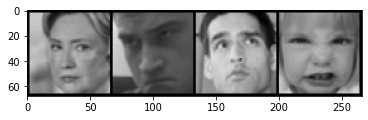

In [ ]:
# show sample images.
for (batch_images, batch_labels) in DataLoader(dataset = fer2013_dataset, batch_size = 4, shuffle = False):
    print('Image Shape:', batch_images.shape) # shape (B, C, H, W)
    print('Label Shape:', batch_labels.shape) 

    grid = torchvision.utils.make_grid(batch_images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    break

## Training Models

### Models

* Initialize G and D, note: discriminator should be called critic,
* According to WGAN paper (since it no longer outputs between [0, 1])

In [ ]:
# Defined by WGAN paper
Z_DIM = 100
CHANNELS_IMG = 1
FEATURES_CRITIC = 16
FEATURES_GEN = 16

device = "cuda" if torch.cuda.is_available() else "cpu"
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

### Optimizer

In [ ]:
# initializate optimizer
# beta1 = 0. beta2 =0.9 by WGAN-GP paper
LEARNING_RATE = 1e-4
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

### Tensorboard

In [ ]:
# for tensorboard plotting
ROOT_PATH = '/content/drive/MyDrive/Datasets/FER2013/'

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"{ROOT_PATH}logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"{ROOT_PATH}logs/GAN_MNIST/fake")
step = 0

### Training Processing

In [ ]:
# mode
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [ ]:
NUM_EPOCHS = 100
# defined by paper
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: 
        # max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        # we need to training critic for more
        for _ in range(CRITIC_ITERATIONS): 
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1) # reshape(-1) to flat
            critic_fake = critic(fake).reshape(-1) # reshape(-1) to flat
            gp = gradient_penalty(critic, real, fake, device=device)
            
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: 
        # max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                # add image to tensorboard
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/100] Batch 100/449                   Loss D: -30.6725, loss G: 32.6298
Epoch [0/100] Batch 200/449                   Loss D: -24.7728, loss G: 35.4939
Epoch [0/100] Batch 300/449                   Loss D: -15.3723, loss G: 36.4262
Epoch [0/100] Batch 400/449                   Loss D: -10.1893, loss G: 31.4238
Epoch [1/100] Batch 100/449                   Loss D: -6.5450, loss G: 32.5598
Epoch [1/100] Batch 200/449                   Loss D: -4.6448, loss G: 29.0546
Epoch [1/100] Batch 300/449                   Loss D: -4.1962, loss G: 28.9264
Epoch [1/100] Batch 400/449                   Loss D: -3.6982, loss G: 28.0181
Epoch [2/100] Batch 100/449                   Loss D: -2.6273, loss G: 27.9390
Epoch [2/100] Batch 200/449                   Loss D: -2.4433, loss G: 23.1258
Epoch [2/100] Batch 300/449                   Loss D: -2.4411, loss G: 24.7605
Epoch [2/100] Batch 400/449                   Loss D: -2.2116, loss G: 24.7424
Epoch [3/100] Batch 100/449                   Lo

## Run Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir PATH_TO_YOUR_TENSORBOARD_LOG_DIR